In [2]:
import numpy as np
import torch
import pandas as pd
import time
import operator
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
CONVERSION_MAP = {0:'00',1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'}
start_time = time.time()
research_date = range(13,31)

# 在bitmex上挂单

bitmex_maker = -0.00025
bitmex_taker = 0.00075

# 在okex上吃单
okex_maker = -0.0001
okex_taker = 0.0002

In [3]:
list1 = []
list2 = []
for date in research_date:
    date_str = CONVERSION_MAP[date] if date in CONVERSION_MAP else str(date)
    list1.append(pd.read_csv('/Users/dear/Desktop/Pythagoras/PC/Depth_201909'+date_str+'_btc_usd.csv',index_col ='LastUpdateId', usecols = ['BidsPrice1', 'AsksPrice1','LastUpdateId']))
    list2.append(pd.read_csv('/Users/dear/Desktop/Pythagoras/Q/Depth_201909'+date_str+'_btc_usd.csv',index_col ='LastUpdateId', usecols =['BidsPrice1', 'AsksPrice1','LastUpdateId']))

excel_file_input1 = pd.concat(list1)
excel_file_input2 = pd.concat(list2)
excel_file_input3 = pd.read_csv('/Users/dear/Desktop/Pythagoras/Funding History  2019-10-30.csv', usecols = ['symbol', 'fundingRate', 'timestamp'])

In [4]:
excel_file_input3['timestamp'] = [datetime.strptime(i,'%Y-%m-%dT%H:%M:%S.%fZ').strftime("%s") for i in excel_file_input3['timestamp']]
excel_file_input3['funding_timestamp'] = excel_file_input3['timestamp'].astype(int)
excel_file_input3['timestamp'] = excel_file_input3['timestamp'].astype(int)-8*60*60
excel_file_input3.drop(excel_file_input3[excel_file_input3['symbol'] != 'XBTUSD' ].index, inplace=True)
excel_file_input3 = excel_file_input3.drop(['symbol'], axis =1)
excel_file_input3 = excel_file_input3.set_index('timestamp')

excel_file_input1.index = (excel_file_input1.index/1000).astype(int)
excel_file_input2.index = (excel_file_input2.index/1000).astype(int)
excel_file_input1=excel_file_input1.reset_index().drop_duplicates(subset='LastUpdateId', keep='first').set_index('LastUpdateId')
excel_file_input2=excel_file_input2.reset_index().drop_duplicates(subset='LastUpdateId', keep='first').set_index('LastUpdateId')

excel_file_input1 = excel_file_input1.rename(columns={"BidsPrice1": "bid_price_bitmex", "AsksPrice1": "ask_price_bitmex"})
excel_file_input2 = excel_file_input2.rename(columns={"BidsPrice1": "bid_price_okex", "AsksPrice1": "ask_price_okex"})
excel_file_input2['contract_exp'] = (1569571200 - excel_file_input2.index)

In [5]:
final_input = pd.merge(excel_file_input1, excel_file_input2, left_index = True, right_index = True, how='outer')
final_input = final_input.join(excel_file_input3)
for item in final_input.columns:
    final_input[item] = final_input[item].interpolate(method='pad')
final_input['funding_exp'] = final_input['funding_timestamp']-final_input.index
final_input = final_input.drop(['funding_timestamp'], axis =1)
final_input = final_input.dropna()

In [6]:
final_input.head(40)


# 在okex买入future（标的为spot index）
# 在Bitmex买入perpetual contract（相当于一天到期的futures），8小时付一次funding rate（根据仓位来交）
# 视作同一个标的，考虑二者差值

,bid_price_bitmex,ask_price_bitmex,bid_price_okex,ask_price_okex,contract_exp,fundingRate,funding_exp
LastUpdateId,,,,,,,
1568376000,10332.0,10332.5,10632.68,10632.69,1195200.0,0.000193,28800.0
1568376001,10332.0,10332.5,10632.68,10632.69,1195199.0,0.000193,28799.0
1568376002,10332.0,10332.5,10632.68,10632.69,1195198.0,0.000193,28798.0
1568376003,10332.0,10332.5,10632.68,10632.69,1195197.0,0.000193,28797.0
1568376004,10332.0,10332.5,10632.68,10632.69,1195196.0,0.000193,28796.0
1568376005,10332.0,10332.5,10632.68,10632.69,1195195.0,0.000193,28795.0
1568376006,10332.0,10332.5,10632.68,10632.69,1195194.0,0.000193,28794.0
1568376007,10332.0,10332.5,10632.68,10632.69,1195193.0,0.000193,28793.0
1568376008,10332.0,10332.5,10632.68,10632.69,1195192.0,0.000193,28792.0


In [7]:
#改动的部分#

final_input['mid_spread'] = (final_input['bid_price_okex']+final_input['ask_price_okex'])/2-(final_input['bid_price_bitmex']+final_input['ask_price_bitmex'])/2
final_input['mid_spread_adjusted'] = final_input['mid_spread']
# 取了okex的价格-bitmex的价格，作为mid_spread
final_input['mid_spread_adjusted'][final_input['funding_exp']<14400] = final_input['mid_spread']-final_input['fundingRate']*final_input['bid_price_bitmex']*(1-final_input['funding_exp']/14400)

In [41]:
final_input['mid_spread_adjusted_ma'] = final_input['mid_spread_adjusted'].rolling(window=12*60*60).mean()
final_input['mid_spread_adjusted_diff'] = final_input['mid_spread_adjusted']-final_input['mid_spread_adjusted_ma']
final_input['mid_spread_adjusted_std'] = final_input['mid_spread_adjusted_diff'].rolling(window=24*60*60).std()
final_input['mid_spread_adjusted_zscore'] = final_input['mid_spread_adjusted_diff']/final_input['mid_spread_adjusted_std']

In [42]:
# 根据MA→Diff→Z-score给出交易信号signal（本质还是moving average的思想）

final_input['signal'] = 0
final_input['signal'][final_input['mid_spread_adjusted_zscore'] > 1] = -0.01
final_input['signal'][final_input['mid_spread_adjusted_zscore'] < -1] = 0.01

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [43]:
# 在某些条件下，根据信号计算position

final_input['position'] = 0
for i in range(2, len(final_input)):
    if final_input['mid_spread'].iloc[i] <= 0 and final_input['position'].iloc[i-1] <= 0:
        final_input['position'].iloc[i] = min(max(final_input['position'].iloc[i-1] + final_input['signal'].iloc[i],final_input['position'].iloc[i-1]),100)
    if final_input['mid_spread'].iloc[i] >= 0 and final_input['position'].iloc[i-1] >= 0:
        final_input['position'].iloc[i] = min(max(final_input['position'].iloc[i-1] + final_input['signal'].iloc[i],-100),final_input['position'].iloc[i-1])
    else:
        final_input['position'].iloc[i] = min(max(final_input['position'].iloc[i-1] + final_input['signal'].iloc[i],-100),100)

# 前后position的差值，表示发生的交易的量        
final_input['transction'] = final_input['position']-final_input['position'].shift(1)
final_input.head(40)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,bid_price_bitmex,ask_price_bitmex,bid_price_okex,ask_price_okex,contract_exp,fundingRate,funding_exp,mid_spread,mid_spread_adjusted,mid_spread_adjusted_ma,mid_spread_adjusted_diff,mid_spread_adjusted_std,mid_spread_adjusted_zscore,signal,position,transction
LastUpdateId,,,,,,,,,,,,,,,,
1568376000,10332.0,10332.5,10632.68,10632.69,1195200.0,0.000193,28800.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1568376001,10332.0,10332.5,10632.68,10632.69,1195199.0,0.000193,28799.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1568376002,10332.0,10332.5,10632.68,10632.69,1195198.0,0.000193,28798.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1568376003,10332.0,10332.5,10632.68,10632.69,1195197.0,0.000193,28797.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1568376004,10332.0,10332.5,10632.68,10632.69,1195196.0,0.000193,28796.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1568376005,10332.0,10332.5,10632.68,10632.69,1195195.0,0.000193,28795.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1568376006,10332.0,10332.5,10632.68,10632.69,1195194.0,0.000193,28794.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1568376007,10332.0,10332.5,10632.68,10632.69,1195193.0,0.000193,28793.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1568376008,10332.0,10332.5,10632.68,10632.69,1195192.0,0.000193,28792.0,300.435,300.435,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [44]:
final_input['transction'].abs().sum()

1949.0600000002178

In [24]:
final_input.fundingRate.min()

3.2e-05

In [47]:
final_input['usd_transaction'] = 0
final_input['funding_transaction'] = 0
final_input['bitmex_position'] = 0
final_input['okex_position'] = 0
final_input['usd_position'] = 0
final_input['net_worth'] = 0


final_input['bitmex_transaction'] = - final_input['transction']
final_input['okex_transaction'] = final_input['transction']
# transaction>0，先在bitmex上挂卖单，再去okex吃买单
final_input['usd_transaction'][final_input['transction']>0] = (final_input['ask_price_bitmex']*(1-bitmex_maker)-final_input['ask_price_okex']*(1+okex_taker))*0.01
# transaction<0，先在bitmex上挂买单，再去okex吃卖单
final_input['usd_transaction'][final_input['transction']<0] = (final_input['bid_price_okex']*(1-okex_taker)-final_input['bid_price_bitmex']*(1+bitmex_maker))*0.01
# 计算两边的仓位
final_input['bitmex_position'] = final_input['bitmex_transaction'].rolling(min_periods=1,window=len(final_input)).sum()
final_input['okex_position'] = final_input['okex_transaction'].rolling(min_periods=1,window=len(final_input)).sum()
# funding金额为bitmex仓位 x price x funding rate
final_input['funding_transaction'][final_input['funding_exp']==1] = -(final_input['fundingRate'] * final_input['bitmex_position']*final_input['ask_price_bitmex'])
final_input['funding_payment'] = final_input['funding_transaction'].rolling(min_periods=1,window=len(final_input)).sum()

final_input['usd_position'] = final_input['usd_transaction'].rolling(min_periods=1,window=len(final_input)).sum()+final_input['funding_payment']
final_input['net_worth'][final_input['position']>0] = final_input['position']*(final_input['bid_price_okex']*(1-okex_taker)-final_input['bid_price_bitmex']*(1+bitmex_maker))+final_input['usd_position']+1000000
final_input['net_worth'][final_input['position']<0] = -final_input['position']*(final_input['ask_price_bitmex']*(1-bitmex_maker)-final_input['ask_price_okex']*(1+okex_taker))+final_input['usd_position']+1000000
final_input['net_worth'][final_input['position']==0] = final_input['usd_position']+1000000

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: Setting

In [48]:
final_input['drawdown'] = (final_input['net_worth'].rolling(min_periods=1,window=len(final_input)).max()-final_input['net_worth'])/final_input['net_worth'].rolling(min_periods=1,window=len(final_input)).max()
final_input['transaction_amount'] = final_input['transction'].abs().rolling(min_periods=1,window=len(final_input)).sum()
final_input['profit_per_trade'] = (final_input['net_worth']-1000000)/final_input['transaction_amount']/final_input['ask_price_bitmex']

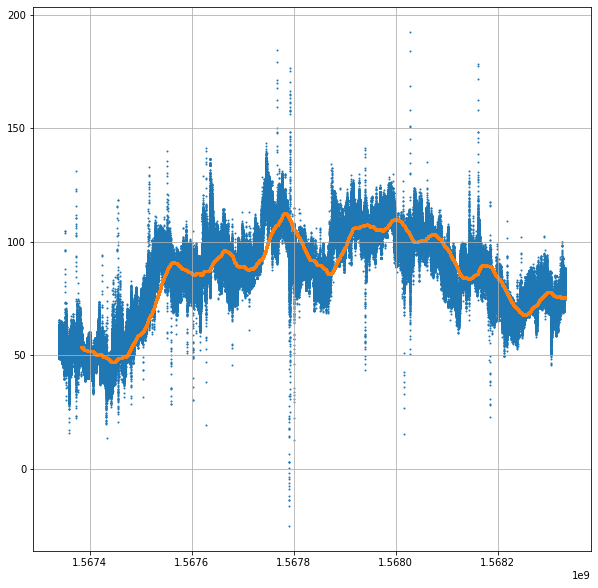

In [28]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['mid_spread_adjusted'],s=1)
plt.scatter(final_input.index, final_input['mid_spread_adjusted_ma'],s=1)
plt.show()

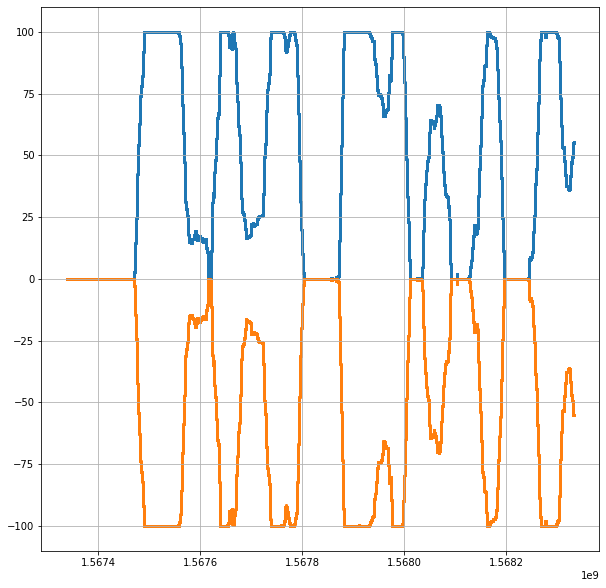

In [29]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['bitmex_position'],s=1)
plt.scatter(final_input.index, final_input['okex_position'],s=1)
plt.show()

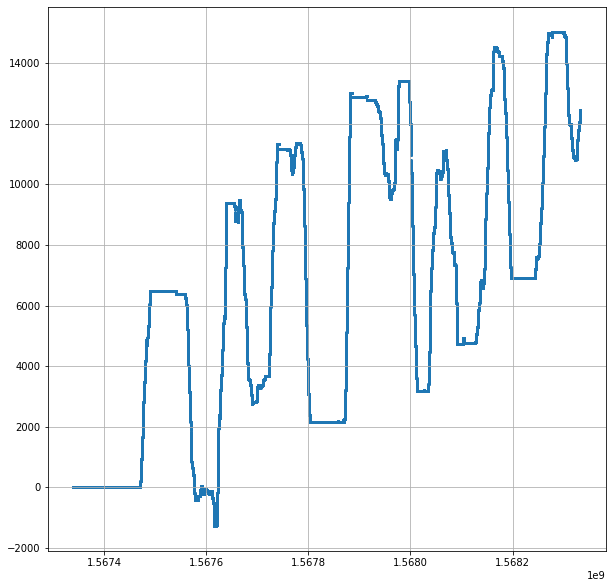

In [30]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['usd_position'],s=1)
plt.show()

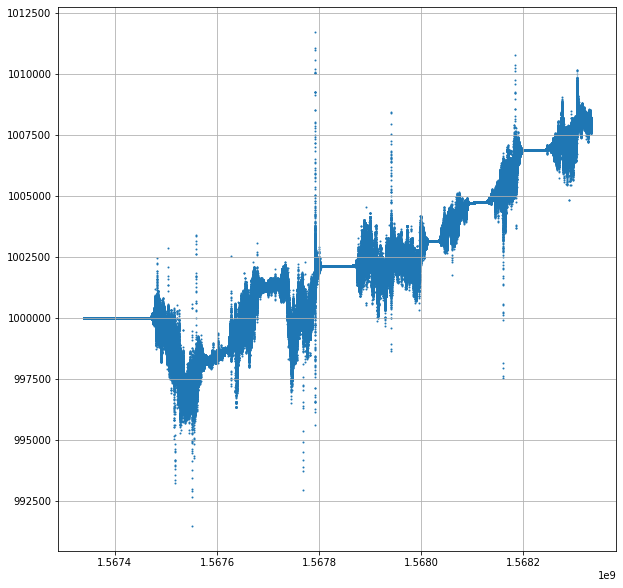

In [31]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['net_worth'],s=1)
plt.show()

In [50]:
final_input['net_worth'].iloc[-1]

1037540.4614409289

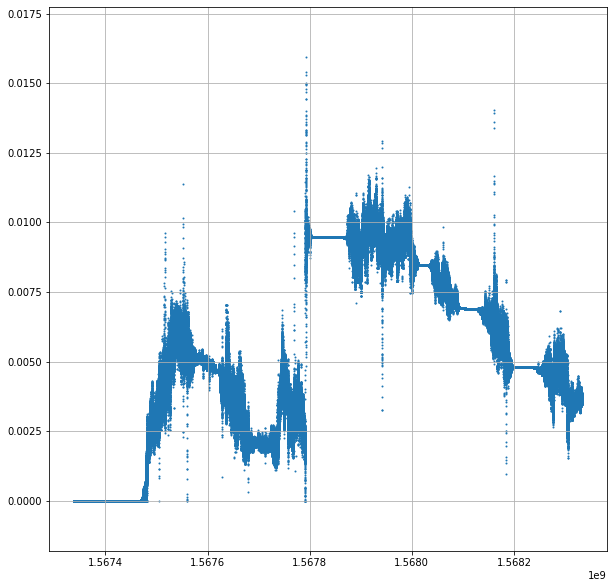

In [32]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['drawdown'],s=1)
plt.show()

In [ ]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['transaction_amount'],s=1)
plt.show()

In [ ]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['profit_per_trade'],s=1)
plt.show()

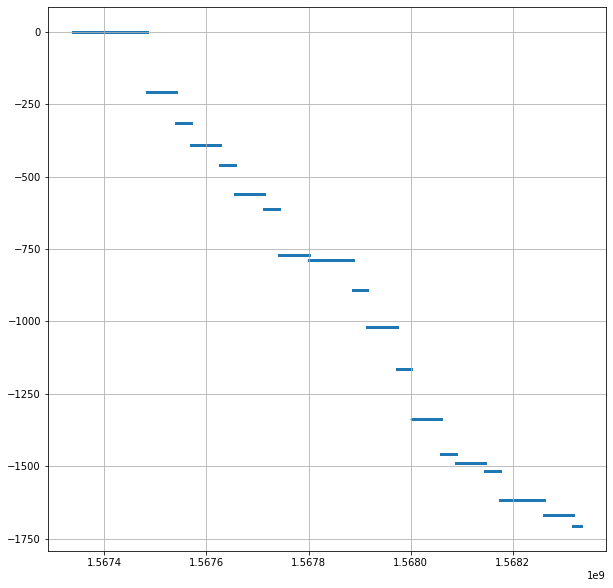

In [33]:
plt.ion()
plt.figure(figsize = (10,10))
plt.grid(True)
plt.scatter(final_input.index, final_input['funding_payment'],s=1)
plt.show()

In [539]:
print((len(final_input)-12*60*60-24*60*60)/60/60/24)

9.997511574074073
